# **Import**

In [1]:
import warnings

warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, mean_absolute_error

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split

# **Data Load**

In [3]:
cd /content/drive/MyDrive/[Projects]/Kaggle/NASA 터보팬 제트 엔진의 잔존 수명 예측 및 예지보전 방안/Data

/content/drive/MyDrive/[Projects]/Kaggle/NASA 터보팬 제트 엔진의 잔존 수명 예측 및 예지보전 방안/Data


In [4]:
index_names = ['unit_number', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = [f's_{i + 1}' for i in range(21)]
col_names = index_names + setting_names + sensor_names

train_df = pd.read_csv('./train_FD003.csv')

In [5]:
max_cycle = train_df.groupby('unit_number')['time_cycles'].max().reset_index()
max_cycle.columns = ['unit_number', 'max_cycle']

train_df = train_df.merge(max_cycle, on='unit_number', how='left')

train_df['RUL'] = train_df['max_cycle'] - train_df['time_cycles']

# **Model**

In [6]:
features = [
    'unit_number', 'time_cycles',
    's_2', 's_3', 's_4', 's_7', 's_8', 's_9', 's_10', 's_11',
    's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21', 'RUL'
]
train_df = train_df[features]
train_df.head()

,unit_number,time_cycles,s_2,s_3,s_4,s_7,s_8,s_9,s_10,s_11,s_12,s_13,s_14,s_15,s_17,s_20,s_21,RUL
0,1,1,642.36,1583.23,1396.84,553.97,2387.96,9062.17,1.3,47.30,522.31,2388.01,8145.32,8.4246,391,39.11,23.3537,258
1,1,2,642.50,1584.69,1396.89,554.55,2388.00,9061.78,1.3,47.23,522.42,2388.03,8152.85,8.4403,392,38.99,23.4491,257
2,1,3,642.18,1582.35,1405.61,554.43,2388.03,9070.23,1.3,47.22,522.03,2388.00,8150.17,8.3901,391,38.85,23.3669,256
3,1,4,642.92,1585.61,1392.27,555.21,2388.00,9064.57,1.3,47.24,522.49,2388.08,8146.56,8.3878,392,38.96,23.2951,255
4,1,5,641.68,1588.63,1397.65,554.74,2388.04,9076.14,1.3,47.15,522.58,2388.03,8147.80,8.3869,392,39.14,23.4583,254


In [7]:
agg_features = []
using_sensor = [
    's_2', 's_3', 's_4', 's_7', 's_8', 's_9', 's_11', 's_12',
    's_13', 's_14', 's_15', 's_17', 's_20', 's_21',
]

for unit in train_df['unit_number'].unique():
    unit_data = train_df[train_df['unit_number'] == unit]
    features = {'unit_number': unit}

    for sensor in using_sensor:
        features[f'{sensor}_mean'] = unit_data[sensor].mean()
        features[f'{sensor}_std'] = unit_data[sensor].std()
        features[f'{sensor}_min'] = unit_data[sensor].min()
        features[f'{sensor}_max'] = unit_data[sensor].max()
        features[f'{sensor}_last'] = unit_data[sensor].iloc[-1]
        features[f'{sensor}_median'] = unit_data[sensor].median()
        features[f'{sensor}_trend'] = np.polyfit(unit_data['time_cycles'], unit_data[sensor], 1)[0]  # 선형 추세

    # RUL도 unit 단위 최대값으로 설정
    features['RUL'] = unit_data['RUL'].max()

    agg_features.append(features)

agg_df = pd.DataFrame(agg_features)

In [8]:
agg_df.head()

,unit_number,s_2_mean,s_2_std,s_2_min,s_2_max,s_2_last,s_2_median,s_2_trend,s_3_mean,s_3_std,...,s_20_median,s_20_trend,s_21_mean,s_21_std,s_21_min,s_21_max,s_21_last,s_21_median,s_21_trend,RUL
0,1,642.573320,0.512974,641.46,644.02,643.94,642.490,0.004740,1589.227027,5.846577,...,38.90,-0.001993,23.321745,0.109115,23.0488,23.5448,23.0707,23.33900,-0.001155,258
1,2,642.231621,0.430092,641.34,643.63,643.35,642.150,0.003652,1585.934822,6.526279,...,39.11,0.001647,23.478945,0.111618,23.2873,23.9159,23.8854,23.44950,0.001077,252
2,3,642.581892,0.513747,641.56,644.23,644.23,642.520,0.006047,1588.531351,6.039755,...,38.91,-0.002103,23.322539,0.108942,23.0379,23.5158,23.1134,23.34305,-0.001298,221
3,4,642.966801,0.416478,642.03,644.47,643.67,642.905,0.003370,1593.218971,4.883964,...,38.75,-0.001285,23.225493,0.085508,22.8995,23.4041,23.0814,23.23035,-0.000693,271
4,5,642.869202,0.432110,641.91,644.45,643.58,642.840,0.004544,1592.133662,5.575543,...,38.78,-0.001841,23.255000,0.090047,22.9625,23.4300,23.0320,23.26960,-0.001028,212


In [9]:
x = agg_df.drop(['unit_number','RUL'], axis=1)
y = agg_df['RUL']

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

## **XGBoost**

In [10]:
xgb_model = XGBRegressor(n_estimators=500, max_depth=6, learning_rate=0.05)
xgb_model.fit(x_train, y_train)
xgb_pred = xgb_model.predict(x_val)

In [11]:
xgb_rmse = np.sqrt(mean_squared_error(y_val, xgb_pred))
xgb_mae = mean_absolute_error(y_val, xgb_pred)

print(f"RMSE: {xgb_rmse:.3f}, MAE: {xgb_mae:.3f}")

RMSE: 23.755, MAE: 16.990


## **LightGBM**

In [12]:
lgb_model = LGBMRegressor(n_estimators=500, max_depth=6, learning_rate=0.05, verbose=-1)
lgb_model.fit(x_train, y_train)
lgb_pred = lgb_model.predict(x_val)

In [13]:
lgb_rmse = np.sqrt(mean_squared_error(y_val, lgb_pred))
lgb_mae = mean_absolute_error(y_val, lgb_pred)

print(f"RMSE: {lgb_rmse:.3f}, MAE: {lgb_mae:.3f}")

RMSE: 24.817, MAE: 23.003


# **Predict RUL**

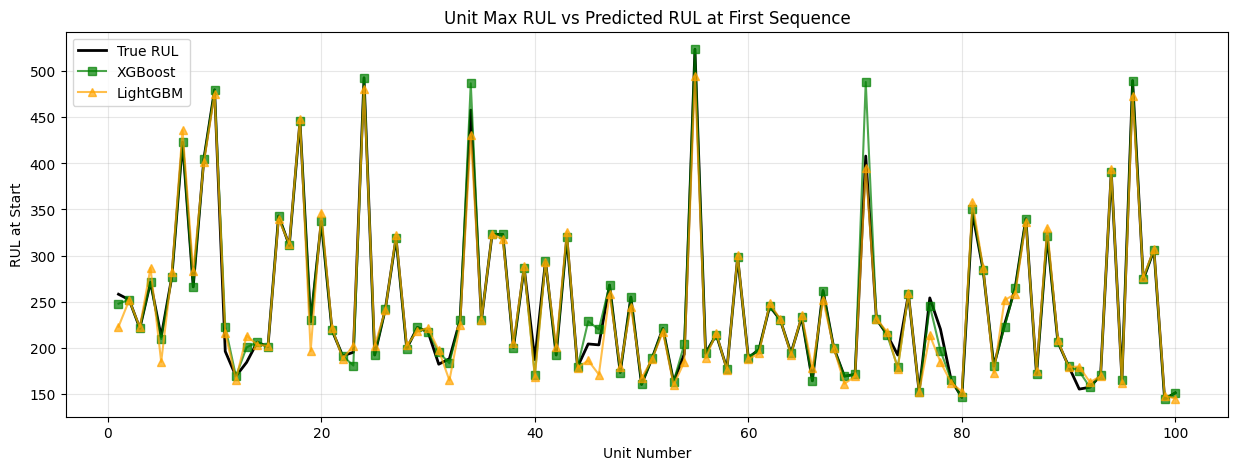

In [14]:
unit_ids = agg_df['unit_number']
true_max_rul = agg_df['RUL']

xgb_pred_full = xgb_model.predict(x)
lgb_pred_full = lgb_model.predict(x)

df_rul_compare = pd.DataFrame({
    'unit_number': unit_ids,
    'True_RUL': true_max_rul,
    'XGB_RUL': xgb_pred_full,
    'LGBM_RUL': lgb_pred_full
})

plt.figure(figsize=(15,5))
plt.plot(df_rul_compare['unit_number'], df_rul_compare['True_RUL'], label='True RUL', color='black', linewidth=2)
plt.plot(df_rul_compare['unit_number'], df_rul_compare['XGB_RUL'], label='XGBoost', color='green', marker='s', alpha=0.7)
plt.plot(df_rul_compare['unit_number'], df_rul_compare['LGBM_RUL'], label='LightGBM', color='orange', marker='^', alpha=0.7)

plt.xlabel('Unit Number')
plt.ylabel('RUL at Start')
plt.title('Unit Max RUL vs Predicted RUL at First Sequence')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# **Test**

In [15]:
test_df = pd.read_csv('./test_FD003.csv')
rul_df = pd.read_csv('./RUL_FD003.csv')

In [16]:
features = [
    'unit_number', 'time_cycles',
    's_2', 's_3', 's_4', 's_7', 's_8', 's_9', 's_10', 's_11',
    's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21'
]
test_df = test_df[features]
test_df.head()

,unit_number,time_cycles,s_2,s_3,s_4,s_7,s_8,s_9,s_10,s_11,s_12,s_13,s_14,s_15,s_17,s_20,s_21
0,1,1,641.94,1581.93,1396.93,554.56,2387.93,9048.65,1.3,47.09,521.89,2387.94,8133.48,8.3760,391,39.07,23.4468
1,1,2,642.02,1584.86,1398.90,554.10,2387.94,9046.53,1.3,47.08,521.85,2388.01,8137.44,8.4062,391,39.04,23.4807
2,1,3,641.68,1581.78,1391.92,554.41,2387.97,9054.92,1.3,47.15,522.10,2387.94,8138.25,8.3553,391,39.10,23.4244
3,1,4,642.20,1584.53,1395.34,554.58,2387.94,9055.04,1.3,47.26,522.45,2387.96,8137.07,8.3709,392,38.97,23.4782
4,1,5,642.46,1589.03,1395.86,554.16,2388.01,9048.59,1.3,46.94,521.91,2387.97,8134.20,8.4146,391,39.09,23.3950


In [17]:
agg_features = []
using_sensor = [
    's_2', 's_3', 's_4', 's_7', 's_8', 's_9', 's_11', 's_12',
    's_13', 's_14', 's_15', 's_17', 's_20', 's_21',
]

for unit in test_df['unit_number'].unique():
    unit_data = test_df[test_df['unit_number'] == unit]
    features = {'unit_number': unit}

    for sensor in using_sensor:
        features[f'{sensor}_mean'] = unit_data[sensor].mean()
        features[f'{sensor}_std'] = unit_data[sensor].std()
        features[f'{sensor}_min'] = unit_data[sensor].min()
        features[f'{sensor}_max'] = unit_data[sensor].max()
        features[f'{sensor}_last'] = unit_data[sensor].iloc[-1]
        features[f'{sensor}_median'] = unit_data[sensor].median()
        features[f'{sensor}_trend'] = np.polyfit(unit_data['time_cycles'], unit_data[sensor], 1)[0]  # 선형 추세

    agg_features.append(features)

agg_df = pd.DataFrame(agg_features)

In [18]:
agg_df.head()

,unit_number,s_2_mean,s_2_std,s_2_min,s_2_max,s_2_last,s_2_median,s_2_trend,s_3_mean,s_3_std,...,s_20_last,s_20_median,s_20_trend,s_21_mean,s_21_std,s_21_min,s_21_max,s_21_last,s_21_median,s_21_trend
0,1,642.193391,0.370289,641.09,643.24,642.59,642.160,0.002385,1584.928112,4.619579,...,39.43,39.100,0.000881,23.457124,0.072123,23.2847,23.6644,23.5679,23.45240,0.000531
1,2,642.542097,0.306953,641.83,643.28,642.56,642.540,0.003183,1588.658226,4.155597,...,38.83,38.855,-0.001270,23.314119,0.068810,23.1469,23.4543,23.2821,23.31420,-0.000867
2,3,642.373932,0.316374,641.62,643.38,642.75,642.370,0.001725,1587.857863,5.267774,...,39.27,39.210,0.001008,23.540120,0.072119,23.3762,23.7643,23.6440,23.53740,0.000543
3,4,642.554853,0.278270,641.86,643.28,642.28,642.535,0.002313,1589.098088,4.379379,...,38.70,38.870,-0.001154,23.314722,0.058762,23.1968,23.4508,23.3804,23.30970,0.000406
4,5,642.053406,0.295584,641.36,642.81,642.15,642.085,-0.001090,1579.612609,4.565141,...,38.89,38.870,0.001287,23.326915,0.081267,23.1570,23.5479,23.4463,23.31315,0.001237


In [19]:
x_test = agg_df.drop(['unit_number'], axis=1)
y_test = rul_df['RUL']

In [20]:
xgb_pred = xgb_model.predict(x_test)

xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
xgb_mae = mean_absolute_error(y_test, xgb_pred)

print(f"RMSE: {xgb_rmse:.3f}, MAE: {xgb_mae:.3f}")

RMSE: 331.993, MAE: 322.904


In [21]:
lgb_pred = lgb_model.predict(x_test)

lgb_rmse = np.sqrt(mean_squared_error(y_test, lgb_pred))
lgb_mae = mean_absolute_error(y_test, lgb_pred)

print(f"RMSE: {lgb_rmse:.3f}, MAE: {lgb_mae:.3f}")

RMSE: 273.611, MAE: 268.233


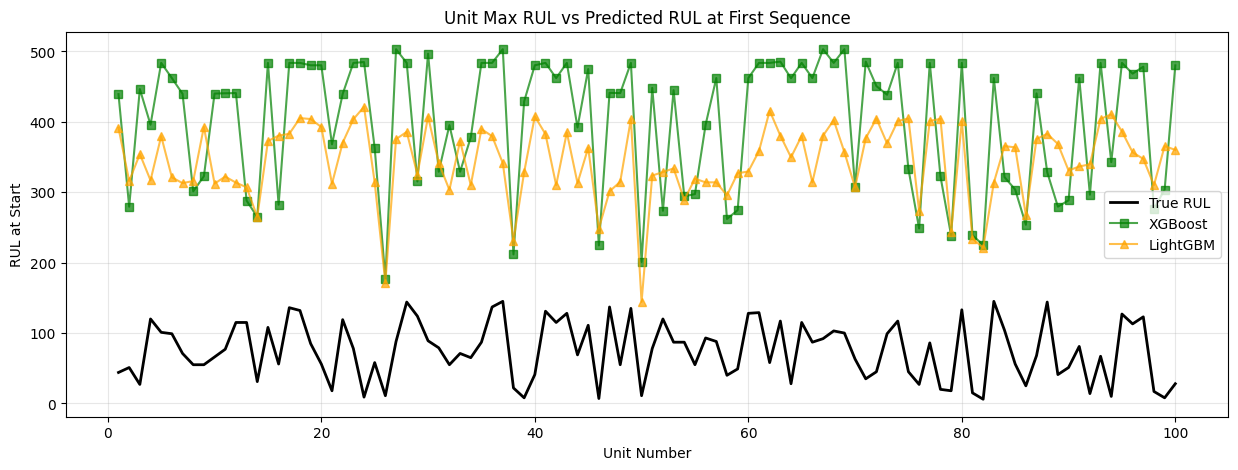

In [22]:
# 주어진 Test Set은 Train Set과 달리 고장 직전 시점까지가 아닌 중간 시점이 주어짐
# 따라서 정확한 고장 시점을 구하기 위해선 전체 통계량이 아닌 시점마다 생성해야함
unit_ids = agg_df['unit_number']
true_max_rul = rul_df['RUL']

xgb_pred_full = xgb_model.predict(x_test)
lgb_pred_full = lgb_model.predict(x_test)

df_rul_compare = pd.DataFrame({
    'unit_number': unit_ids,
    'True_RUL': true_max_rul,
    'XGB_RUL': xgb_pred_full,
    'LGBM_RUL': lgb_pred_full
})

plt.figure(figsize=(15,5))
plt.plot(df_rul_compare['unit_number'], df_rul_compare['True_RUL'], label='True RUL', color='black', linewidth=2)
plt.plot(df_rul_compare['unit_number'], df_rul_compare['XGB_RUL'], label='XGBoost', color='green', marker='s', alpha=0.7)
plt.plot(df_rul_compare['unit_number'], df_rul_compare['LGBM_RUL'], label='LightGBM', color='orange', marker='^', alpha=0.7)

plt.xlabel('Unit Number')
plt.ylabel('RUL at Start')
plt.title('Unit Max RUL vs Predicted RUL at First Sequence')
plt.legend()
plt.grid(alpha=0.3)
plt.show()